# Stage 2 - Lesson 2: Feature Engineering with MLflow

## Overview

In this notebook, we'll learn how to track feature engineering experiments using MLflow. Feature engineering is a critical step in time series forecasting, and keeping track of different feature combinations helps us understand what works best.

### Learning Objectives:
1. Track feature engineering experiments with MLflow
2. Compare different feature sets
3. Visualize feature importance
4. Detect and monitor feature drift
5. Version feature sets for reproducibility

Let's get started!

## 1. Setup and Import Libraries

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# MLflow
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient

# Model related
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# MLflow tracking setup
# Using a local MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Set the experiment name for feature engineering
experiment_name = "google_stock_feature_engineering"

# Create the experiment if it doesn't exist
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(name=experiment_name)
    print(f"Created new experiment: {experiment_name} with ID: {experiment_id}")
else:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f"Using existing experiment: {experiment_name} with ID: {experiment_id}")

# Set this as our active experiment
mlflow.set_experiment(experiment_name)

Using existing experiment: google_stock_feature_engineering with ID: 866255455360708975


<Experiment: artifact_location='file:C:/Users/hohoy/OneDrive/Desktop/sagemaker-ncf-mlflow/tutorial_notebook/stage2/notebooks/../mlruns/google_stock_feature_engineering', creation_time=1739945609024, experiment_id='866255455360708975', last_update_time=1739945609024, lifecycle_stage='active', name='google_stock_feature_engineering', tags={}>

## 2. Load and Prepare Data

We'll use the historical data from our previous split. This follows best practices where we use historical data for model development and keep future data separate for final validation.

In [3]:
def load_data(file_path):
    """Load and preprocess data"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
        
    # Load the data
    df = pd.read_csv(file_path)
    
    # Convert date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

# Load historical data (we'll use this for feature engineering)
historical_data_path = '../../data/mlops_stages/historical_features.csv'
try:
    df = load_data(historical_data_path)
    print(f"Loaded historical data with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please run the Stage 2 Lesson 1 notebook first to generate the split data.")

df.head()

Loaded historical data with 802 rows and 305 columns
Date range: 2021-06-16 00:00:00+00:00 to 2024-08-22 00:00:00+00:00


,Date,Adj Close,Volume,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,...,Volume_lag_293,Volume_lag_294,Volume_lag_295,Volume_lag_296,Volume_lag_297,Volume_lag_298,Volume_lag_299,Volume_lag_300,Volume_rolling_mean_3,target
0,2021-06-16 00:00:00+00:00,120.980934,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,24120000.0,24458000.0,...,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,61620000.0,63320000.0,2.332000e+07,120.772499
1,2021-06-17 00:00:00+00:00,120.336266,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,24120000.0,...,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,61620000.0,2.187267e+07,121.743500
2,2021-06-18 00:00:00+00:00,121.303764,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,...,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,2.337733e+07,120.111000
3,2021-06-21 00:00:00+00:00,119.677162,46116000.0,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,...,49648000.0,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,2.462533e+07,121.812500
4,2021-06-22 00:00:00+00:00,121.372513,27414000.0,46116000.0,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,...,46296000.0,49648000.0,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,3.281000e+07,122.330498


In [4]:
def time_based_train_valid_test_split(df, test_size=0.2, valid_size=0.1):
    """Split time series data into train, validation and test sets"""
    # Sort by date
    df = df.sort_values('Date')
    
    # Calculate split indices
    n = len(df)
    test_idx = int(n * (1 - test_size))
    valid_idx = int(test_idx * (1 - valid_size))
    
    # Split the data
    train_df = df.iloc[:valid_idx].copy()
    valid_df = df.iloc[valid_idx:test_idx].copy()
    test_df = df.iloc[test_idx:].copy()
    
    print(f"Train period: {train_df['Date'].min()} to {train_df['Date'].max()} ({len(train_df)} days)")
    print(f"Validation period: {valid_df['Date'].min()} to {valid_df['Date'].max()} ({len(valid_df)} days)")
    print(f"Test period: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")
    
    return train_df, valid_df, test_df

# Split the data
train_df, valid_df, test_df = time_based_train_valid_test_split(df)

Train period: 2021-06-16 00:00:00+00:00 to 2023-09-28 00:00:00+00:00 (576 days)
Validation period: 2023-09-29 00:00:00+00:00 to 2024-01-02 00:00:00+00:00 (65 days)
Test period: 2024-01-03 00:00:00+00:00 to 2024-08-22 00:00:00+00:00 (161 days)


## 3. Analyze Feature Distribution

Before we start creating feature sets, let's analyze the types of features we already have.

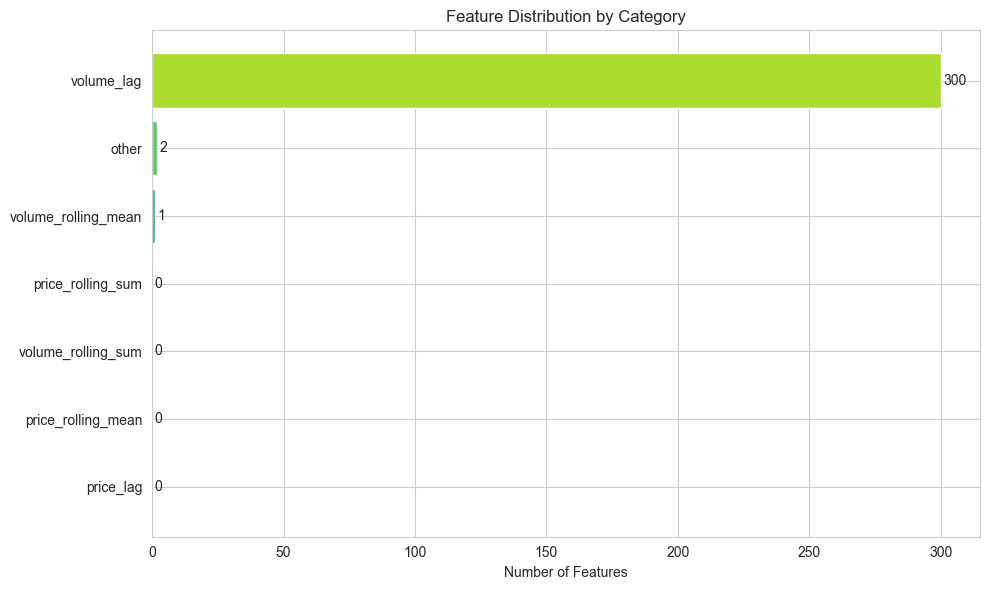

🏃 View run feature_analysis at: http://localhost:5000/#/experiments/866255455360708975/runs/6305869dc60c4d11a63298a3f4a3dfa1
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


In [5]:
def analyze_feature_types(df):
    """Analyze and categorize features"""
    feature_cols = [col for col in df.columns if col not in ['Date', 'target']]
    
    # Categorize features
    feature_categories = {
        'price_lag': [col for col in feature_cols if any(f"{price}_lag_" in col for price in ['Open', 'High', 'Low', 'Close', 'Adj Close'])],
        'volume_lag': [col for col in feature_cols if 'Volume_lag_' in col],
        'price_rolling_mean': [col for col in feature_cols if any(f"{price}_rolling_mean_" in col for price in ['Open', 'High', 'Low', 'Close', 'Adj Close'])],
        'volume_rolling_mean': [col for col in feature_cols if 'Volume_rolling_mean_' in col],
        'price_rolling_sum': [col for col in feature_cols if any(f"{price}_rolling_sum_" in col for price in ['Open', 'High', 'Low', 'Close', 'Adj Close'])],
        'volume_rolling_sum': [col for col in feature_cols if 'Volume_rolling_sum_' in col],
        'other': []
    }
    
    # Check for other features
    categorized = []
    for category in feature_categories:
        categorized.extend(feature_categories[category])
    
    feature_categories['other'] = [col for col in feature_cols if col not in categorized]
    
    # Summary
    summary = {category: len(features) for category, features in feature_categories.items()}
    
    return feature_categories, summary

feature_categories, summary = analyze_feature_types(df)

# Plot the distribution
plt.figure(figsize=(10, 6))
categories = list(summary.keys())
counts = list(summary.values())

# Sort by count
sorted_indices = np.argsort(counts)
categories = [categories[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

bars = plt.barh(categories, counts, color=sns.color_palette("viridis", len(categories)))
plt.xlabel('Number of Features')
plt.title('Feature Distribution by Category')

# Add the exact count at the end of each bar
for i, (count, bar) in enumerate(zip(counts, bars)):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(count), va='center')

plt.tight_layout()
plt.show()

# Log this chart in MLflow
with mlflow.start_run(run_name="feature_analysis"):
    # Save figure for logging
    plt.figure(figsize=(10, 6))
    bars = plt.barh(categories, counts, color=sns.color_palette("viridis", len(categories)))
    plt.xlabel('Number of Features')
    plt.title('Feature Distribution by Category')
    for i, (count, bar) in enumerate(zip(counts, bars)):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(count), va='center')
    plt.tight_layout()
    plt.savefig("outputs/feature_distribution.png")
    plt.close()
    
    # Log as artifact
    mlflow.log_artifact("outputs/feature_distribution.png", "visualizations")
    
    # Log feature counts as metrics
    for category, count in summary.items():
        mlflow.log_metric(f"outputs/feature_count_{category}", count)
    
    # Log total feature count
    mlflow.log_metric("outputs/total_feature_count", sum(summary.values()))

## 4. Create Feature Sets

Now let's create different feature sets and track them with MLflow. We'll explore several strategies:

1. **Time-based selection**: Features from different time windows
2. **Statistical selection**: Using correlation and mutual information
3. **Combined approach**: Mixing different feature types

For each approach, we'll log the feature selection process in MLflow.

In [6]:
def prepare_features_target(df):
    """Extract features and target from dataframe"""
    # Get feature columns (excluding Date and target)
    feature_cols = [col for col in df.columns if col not in ['Date', 'target']]
    
    # Extract features and target
    X = df[feature_cols]
    y = df['target']
    
    return X, y, feature_cols

### 4.1 Feature Set 1: Time-based Selection

Let's create feature sets based on different time windows. We'll track this process with MLflow.

In [7]:
def create_time_window_features(df, short_term=7, medium_term=30, long_term=90):
    """Create feature sets based on different time windows"""
    feature_cols = [col for col in df.columns if col not in ['Date', 'target']]
    
    # Short-term features (recent days)
    short_term_features = [
        col for col in feature_cols 
        if ('_lag_' in col and int(col.split('_lag_')[1]) <= short_term) or
           ('_rolling_mean_' in col and int(col.split('_rolling_mean_')[1]) <= short_term) or
           ('_rolling_sum_' in col and int(col.split('_rolling_sum_')[1]) <= short_term)
    ]
    
    # Medium-term features
    medium_term_features = [
        col for col in feature_cols 
        if ('_lag_' in col and short_term < int(col.split('_lag_')[1]) <= medium_term) or
           ('_rolling_mean_' in col and short_term < int(col.split('_rolling_mean_')[1]) <= medium_term) or
           ('_rolling_sum_' in col and short_term < int(col.split('_rolling_sum_')[1]) <= medium_term)
    ]
    
    # Long-term features
    long_term_features = [
        col for col in feature_cols 
        if ('_lag_' in col and medium_term < int(col.split('_lag_')[1]) <= long_term) or
           ('_rolling_mean_' in col and medium_term < int(col.split('_rolling_mean_')[1]) <= long_term) or
           ('_rolling_sum_' in col and medium_term < int(col.split('_rolling_sum_')[1]) <= long_term)
    ]
    
    # Base features (the raw price and volume columns)
    base_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'] 
    base_features = [col for col in base_features if col in feature_cols]
    
    # Create the combined feature sets
    feature_sets = {
        'base_only': base_features,
        'short_term_only': short_term_features,
        'medium_term_only': medium_term_features,
        'long_term_only': long_term_features,
        'short_and_medium': short_term_features + medium_term_features,
        'all_time_windows': short_term_features + medium_term_features + long_term_features,
        'base_with_short': base_features + short_term_features,
        'base_with_all': base_features + short_term_features + medium_term_features + long_term_features
    }
    
    return feature_sets

# Create time-based feature sets
time_feature_sets = create_time_window_features(train_df)

# Display summary
print("Time-based Feature Sets:")
for set_name, features in time_feature_sets.items():
    print(f"  {set_name}: {len(features)} features")

Time-based Feature Sets:
  base_only: 2 features
  short_term_only: 8 features
  medium_term_only: 23 features
  long_term_only: 60 features
  short_and_medium: 31 features
  all_time_windows: 91 features
  base_with_short: 10 features
  base_with_all: 93 features


### 4.2 Feature Set 2: Statistical Selection

Let's use statistical methods to select features and track the process with MLflow.

In [8]:
def create_statistical_feature_sets(X, y, feature_names):
    """Create feature sets using statistical selection methods"""
    
    # Correlation-based selection (F-regression)
    k_correlation = min(50, X.shape[1])  # Select top 50 features or less if fewer features exist
    selector_correlation = SelectKBest(f_regression, k=k_correlation)
    selector_correlation.fit(X, y)
    correlation_scores = selector_correlation.scores_
    correlation_features = [feature_names[i] for i in selector_correlation.get_support(indices=True)]
    
    # Mutual information selection
    k_mutual_info = min(50, X.shape[1])
    selector_mutual = SelectKBest(mutual_info_regression, k=k_mutual_info)
    selector_mutual.fit(X, y)
    mutual_info_scores = selector_mutual.scores_
    mutual_info_features = [feature_names[i] for i in selector_mutual.get_support(indices=True)]
    
    # Top features by correlation
    top_10_correlation = [feature_names[i] for i in np.argsort(correlation_scores)[-10:]]
    top_25_correlation = [feature_names[i] for i in np.argsort(correlation_scores)[-25:]]
    
    # Top features by mutual information
    top_10_mutual = [feature_names[i] for i in np.argsort(mutual_info_scores)[-10:]]
    top_25_mutual = [feature_names[i] for i in np.argsort(mutual_info_scores)[-25:]]
    
    # Combined approach - features that appear in both methods
    combined_10 = list(set(top_10_correlation).intersection(set(top_10_mutual)))
    combined_25 = list(set(top_25_correlation).intersection(set(top_25_mutual)))
    
    # Create feature sets
    feature_sets = {
        'top_10_correlation': top_10_correlation,
        'top_25_correlation': top_25_correlation,
        'top_10_mutual_info': top_10_mutual,
        'top_25_mutual_info': top_25_mutual,
        'combined_top_10': combined_10,
        'combined_top_25': combined_25,
        'all_correlation_selected': correlation_features,
        'all_mutual_info_selected': mutual_info_features
    }
    
    return feature_sets, correlation_scores, mutual_info_scores

# Extract features and target
X_train, y_train, feature_names = prepare_features_target(train_df)

# Create statistical feature sets
statistical_feature_sets, correlation_scores, mutual_info_scores = create_statistical_feature_sets(
    X_train.values, y_train.values, feature_names
)

# Display summary
print("\nStatistical Feature Sets:")
for set_name, features in statistical_feature_sets.items():
    print(f"  {set_name}: {len(features)} features")


Statistical Feature Sets:
  top_10_correlation: 10 features
  top_25_correlation: 25 features
  top_10_mutual_info: 10 features
  top_25_mutual_info: 25 features
  combined_top_10: 1 features
  combined_top_25: 3 features
  all_correlation_selected: 50 features
  all_mutual_info_selected: 50 features


### 4.3 Log Feature Sets in MLflow

Now, let's log both feature selection approaches in MLflow.

In [9]:
# Log time-based feature sets
with mlflow.start_run(run_name="time_based_feature_selection"):
    # Log parameters
    mlflow.log_param("feature_selection_method", "time_window_based")
    mlflow.log_param("short_term_window", 7)
    mlflow.log_param("medium_term_window", 30)
    mlflow.log_param("long_term_window", 90)
    
    # Log metrics (feature counts)
    for set_name, features in time_feature_sets.items():
        mlflow.log_metric(f"feature_count_{set_name}", len(features))
    
    # Log feature lists as artifacts
    os.makedirs("outputs/feature_sets", exist_ok=True)
    for set_name, features in time_feature_sets.items():
        with open(f"outputs/feature_sets/{set_name}.txt", "w") as f:
            f.write("\n".join(features))
    
    # Log the feature sets directory
    mlflow.log_artifacts("outputs/feature_sets", "time_based_feature_sets")
    
    # Set tags
    mlflow.set_tag("feature_engineering_approach", "time_window_based")
    mlflow.set_tag("feature_version", "v1")

# Log statistical feature sets
with mlflow.start_run(run_name="statistical_feature_selection"):
    # Log parameters
    mlflow.log_param("feature_selection_method", "statistical")
    mlflow.log_param("correlation_method", "f_regression")
    mlflow.log_param("mutual_info_method", "mutual_info_regression")
    
    # Log metrics (feature counts)
    for set_name, features in statistical_feature_sets.items():
        mlflow.log_metric(f"feature_count_{set_name}", len(features))
    
    # Plot and log top feature importance
    plt.figure(figsize=(12, 8))
    
    # Get top 15 features by correlation
    top_indices = np.argsort(correlation_scores)[-15:]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = correlation_scores[top_indices]
    
    # Plot
    plt.barh(range(len(top_features)), top_scores, align='center')
    plt.yticks(range(len(top_features)), [f.split('_lag_')[0] if '_lag_' in f else f for f in top_features])
    plt.xlabel('F-Score (Correlation)')
    plt.title('Top 15 Features by F-Regression Score')
    plt.tight_layout()
    plt.savefig("outputs/top_features_correlation.png")
    plt.close()
    
    # Log the visualization
    mlflow.log_artifact("outputs/top_features_correlation.png", "feature_importance")
    
    # Plot and log mutual information
    plt.figure(figsize=(12, 8))
    
    # Get top 15 features by mutual information
    top_indices = np.argsort(mutual_info_scores)[-15:]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = mutual_info_scores[top_indices]
    
    # Plot
    plt.barh(range(len(top_features)), top_scores, align='center')
    plt.yticks(range(len(top_features)), [f.split('_lag_')[0] if '_lag_' in f else f for f in top_features])
    plt.xlabel('Mutual Information Score')
    plt.title('Top 15 Features by Mutual Information')
    plt.tight_layout()
    plt.savefig("outputs/top_features_mutual_info.png")
    plt.close()
    
    # Log the visualization
    mlflow.log_artifact("outputs/top_features_mutual_info.png", "feature_importance")
    
    # Log feature lists as artifacts
    os.makedirs("outputs/statistical_feature_sets", exist_ok=True)
    for set_name, features in statistical_feature_sets.items():
        with open(f"outputs/statistical_feature_sets/{set_name}.txt", "w") as f:
            f.write("\n".join(features))
    
    # Log the feature sets directory
    mlflow.log_artifacts("outputs/statistical_feature_sets", "outputs/statistical_feature_sets")
    
    # Set tags
    mlflow.set_tag("feature_engineering_approach", "statistical")
    mlflow.set_tag("feature_version", "v1")

🏃 View run time_based_feature_selection at: http://localhost:5000/#/experiments/866255455360708975/runs/ad26f39b579d42cc9c4fcf8427e02693
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975
🏃 View run statistical_feature_selection at: http://localhost:5000/#/experiments/866255455360708975/runs/e9c4187bdc0a4d39bcd7ea328a019ddf
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


## 5. Evaluate Feature Sets

Now let's evaluate our feature sets using a simple XGBoost model. We'll track performance for each feature set in MLflow.

In [10]:
# Calculate direction accuracy
def calculate_direction_accuracy(y_true, y_pred):
    """Calculate how often we correctly predict price movement direction"""
    y_true_direction = np.diff(y_true) > 0  # True if price went up
    y_pred_direction = np.diff(y_pred) > 0  # True if we predicted price would go up
    accuracy = np.mean(y_true_direction == y_pred_direction)
    return accuracy
def evaluate_feature_set(feature_set_name, features, run_name=None):
    """Evaluate a feature set using XGBoost and log in MLflow"""
    # If no run name is provided, use feature set name
    if run_name is None:
        run_name = f"evaluate_{feature_set_name}"

    # Get train, validation, and test data with selected features
    X_train_selected = train_df[features]
    y_train = train_df['target']
    
    X_valid_selected = valid_df[features]
    y_valid = valid_df['target']
    
    X_test_selected = test_df[features]
    y_test = test_df['target']
    
    # Define model parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.05,
        'max_depth': 5,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
        'early_stopping_rounds': 10
    }
    
    # Start a new MLflow run
    with mlflow.start_run(run_name=run_name):
        # Log feature set info
        mlflow.log_param("feature_set", feature_set_name)
        mlflow.log_param("num_features", len(features))
        
        # Log model parameters
        for param, value in params.items():
            mlflow.log_param(param, value)
        
        # Train the model
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train_selected, y_train,
            eval_set=[(X_valid_selected, y_valid)],
            verbose=False
        )
        
        # Make predictions
        y_train_pred = model.predict(X_train_selected)
        y_valid_pred = model.predict(X_valid_selected)
        y_test_pred = model.predict(X_test_selected)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        valid_mae = mean_absolute_error(y_valid, y_valid_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        train_direction_accuracy = calculate_direction_accuracy(y_train, y_train_pred)
        valid_direction_accuracy = calculate_direction_accuracy(y_valid, y_valid_pred)
        test_direction_accuracy = calculate_direction_accuracy(y_test, y_test_pred)

        train_r2 = r2_score(y_train, y_train_pred)
        valid_r2 = r2_score(y_valid, y_valid_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Log metrics
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("valid_rmse", valid_rmse)
        mlflow.log_metric("test_rmse", test_rmse)
        
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("valid_mae", valid_mae)
        mlflow.log_metric("test_mae", test_mae)
        
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("valid_r2", valid_r2)
        mlflow.log_metric("test_r2", test_r2)

        mlflow.log_metric("train_direction_accuracy", train_direction_accuracy)
        mlflow.log_metric("valid_direction_accuracy", valid_direction_accuracy)
        mlflow.log_metric("test_direction_accuracy", test_direction_accuracy)
        
        # Return metrics for comparison
        run_id = mlflow.active_run().info.run_id
        return {
            'feature_set': feature_set_name,
            'num_features': len(features),
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            "test_direction_accuracy":test_direction_accuracy,
            'test_r2': test_r2,
            'run_id': run_id
        }

# Evaluate selected feature sets
results = []

# Evaluate time-based feature sets
for feature_set_name in ['short_term_only', 'medium_term_only', 'all_time_windows']:
    result = evaluate_feature_set(
        feature_set_name,
        time_feature_sets[feature_set_name],
        f"time_based_{feature_set_name}"
    )
    results.append(result)

# Evaluate base model with all features for comparison
all_features = [col for col in train_df.columns if col not in ['Date', 'target']]
result = evaluate_feature_set(
    'all_features',
    all_features,
    'baseline_all_features'
)
results.append(result)

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_rmse')
results_df


🏃 View run time_based_short_term_only at: http://localhost:5000/#/experiments/866255455360708975/runs/35474808d26f41afb31619bab06ef642
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975
🏃 View run time_based_medium_term_only at: http://localhost:5000/#/experiments/866255455360708975/runs/ac2b6adc763e4f608c45e3b717094c7b
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975
🏃 View run time_based_all_time_windows at: http://localhost:5000/#/experiments/866255455360708975/runs/d537e007e0cf492dbd08fcaec577c273
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975
🏃 View run baseline_all_features at: http://localhost:5000/#/experiments/866255455360708975/runs/5ebaeb7a22bb418e90c3cc1551f76197
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


,feature_set,num_features,test_rmse,test_mae,test_direction_accuracy,test_r2,run_id
3,all_features,303,22.720398,18.000780,0.54375,-1.073550,5ebaeb7a22bb418e90c3cc1551f76197
2,all_time_windows,91,37.141150,34.248209,0.46875,-4.541065,d537e007e0cf492dbd08fcaec577c273
1,medium_term_only,23,40.455269,37.910475,0.53125,-5.574046,ac2b6adc763e4f608c45e3b717094c7b
0,short_term_only,8,42.927079,39.962435,0.46875,-6.401934,35474808d26f41afb31619bab06ef642


## 6. Compare Feature Set Performance

Let's visualize our results to see which feature sets performed best.

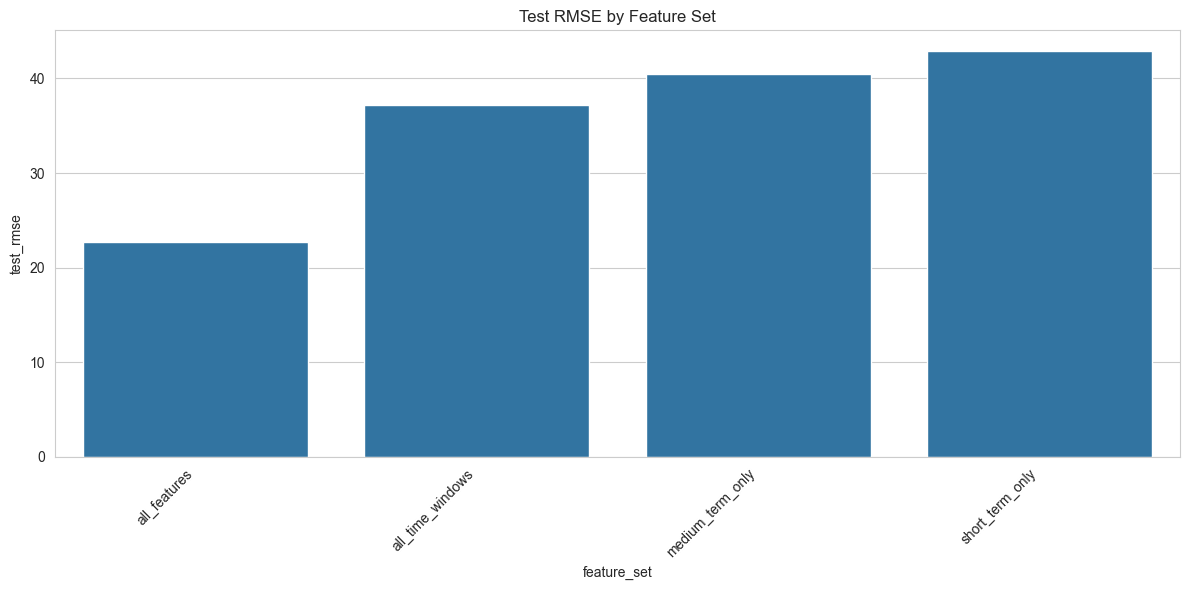

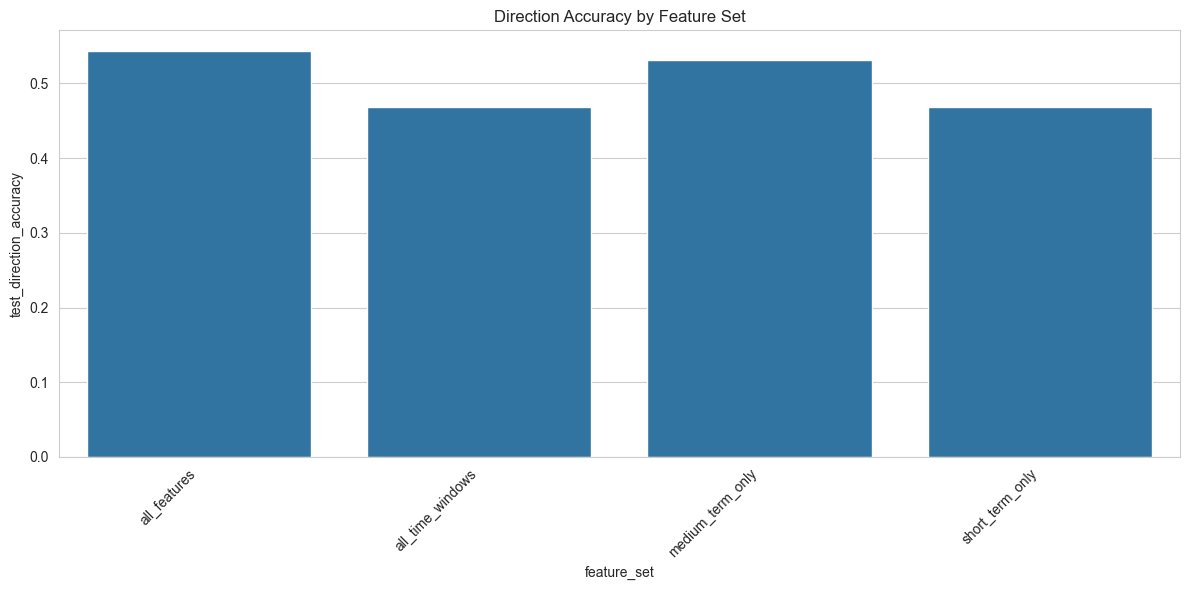

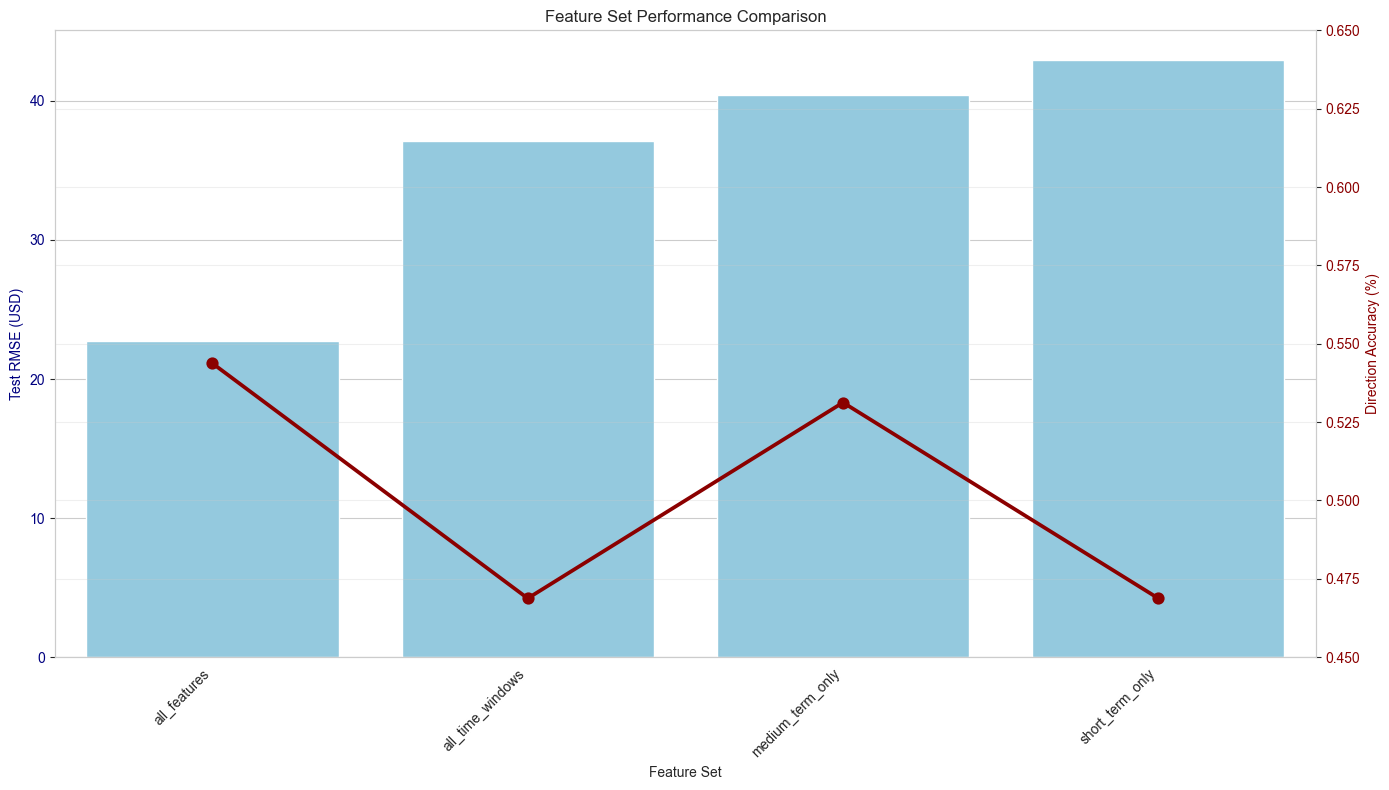

🏃 View run feature_set_comparison at: http://localhost:5000/#/experiments/866255455360708975/runs/d2b2bb789eee4023aefc4c7f027b10b2
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


In [11]:
# Create comparative visualizations
plt.figure(figsize=(12, 6))
sns.barplot(x='feature_set', y='test_rmse', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('Test RMSE by Feature Set')
plt.tight_layout()
plt.savefig("outputs/feature_set_comparison_rmse.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='feature_set', y='test_direction_accuracy', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('Direction Accuracy by Feature Set')
plt.tight_layout()
plt.savefig("outputs/feature_set_comparison_direction.png")
plt.show()

# Create a comparison plot with both metrics
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(111)

# First y-axis for RMSE
barplot = sns.barplot(x='feature_set', y='test_rmse', data=results_df, color='skyblue', ax=ax1)
ax1.set_xlabel('Feature Set')
ax1.set_ylabel('Test RMSE (USD)', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
plt.xticks(rotation=45, ha='right')

# Second y-axis for direction accuracy
ax2 = ax1.twinx()
sns.pointplot(x='feature_set', y='test_direction_accuracy', data=results_df, color='darkred', ax=ax2)
ax2.set_ylabel('Direction Accuracy (%)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(0.45, 0.65)  # Adjust based on your actual values

plt.title('Feature Set Performance Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/feature_set_dual_metrics.png")
plt.show()

# Log these visualizations in MLflow
with mlflow.start_run(run_name="feature_set_comparison"):
    mlflow.log_artifact("outputs/feature_set_comparison_rmse.png", "comparisons")
    mlflow.log_artifact("outputs/feature_set_comparison_direction.png", "comparisons")
    mlflow.log_artifact("outputs/feature_set_dual_metrics.png", "comparisons")
    
    # Log best feature set information
    best_rmse_set = results_df.iloc[0]['feature_set']
    best_direction_set = results_df.sort_values('test_direction_accuracy', ascending=False).iloc[0]['feature_set']
    
    mlflow.log_param("best_rmse_feature_set", best_rmse_set)
    mlflow.log_param("best_direction_feature_set", best_direction_set)
    mlflow.log_metric("best_rmse", results_df.iloc[0]['test_rmse'])
    mlflow.log_metric("best_direction_accuracy", results_df.sort_values('test_direction_accuracy', ascending=False).iloc[0]['test_direction_accuracy'])

## 7. Feature Drift Monitoring

An important aspect of feature engineering in time series is monitoring for feature drift over time. Let's explore how to track this with MLflow.

In [12]:
def analyze_feature_drift(train_df, test_df, feature_set):
    """Analyze how feature distributions drift between train and test periods"""
    drift_metrics = {}
    feature_drift_plots = []
    
    # For each feature, calculate distribution stats and create comparison plots
    for feature in feature_set:
        if feature in train_df.columns and feature in test_df.columns:
            # Calculate distribution statistics
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            mean_diff_pct = abs((test_mean - train_mean) / train_mean * 100) if train_mean != 0 else 0
            
            train_std = train_df[feature].std()
            test_std = test_df[feature].std()
            std_diff_pct = abs((test_std - train_std) / train_std * 100) if train_std != 0 else 0
            
            # Store metrics
            drift_metrics[f"{feature}_mean_drift_pct"] = mean_diff_pct
            drift_metrics[f"{feature}_std_drift_pct"] = std_diff_pct
            
            # Create distribution comparison plot for this feature
            if len(feature_drift_plots) < 5:  # Limit to 5 plots to avoid generating too many
                plt.figure(figsize=(10, 6))
                sns.histplot(train_df[feature], color='blue', alpha=0.5, label='Train')
                sns.histplot(test_df[feature], color='red', alpha=0.5, label='Test')
                plt.title(f'Distribution Drift: {feature}')
                plt.legend()
                plt.tight_layout()
                plot_filename = f"outputs/drift_{feature.replace('/', '_')}.png"
                plt.savefig(plot_filename)
                plt.close()
                feature_drift_plots.append(plot_filename)
    
    return drift_metrics, feature_drift_plots

# Analyze drift for our best performing feature set
best_feature_set_name = results_df.iloc[0]['feature_set']
if best_feature_set_name in time_feature_sets:
    best_features = time_feature_sets[best_feature_set_name]
elif best_feature_set_name in statistical_feature_sets:
    best_features = statistical_feature_sets[best_feature_set_name]
else:
    best_features = [col for col in train_df.columns if col not in ['Date', 'target']]

# Analyze drift between train and test sets
drift_metrics, drift_plots = analyze_feature_drift(train_df, test_df, best_features)

# Log drift analysis in MLflow
with mlflow.start_run(run_name="feature_drift_analysis"):
    # Log parameters
    mlflow.log_param("feature_set_analyzed", best_feature_set_name)
    mlflow.log_param("train_period", f"{train_df['Date'].min()} to {train_df['Date'].max()}")
    mlflow.log_param("test_period", f"{test_df['Date'].min()} to {test_df['Date'].max()}")
    
    # Log metrics
    # Calculate average drift across features
    mean_drifts = [v for k, v in drift_metrics.items() if 'mean_drift' in k]
    std_drifts = [v for k, v in drift_metrics.items() if 'std_drift' in k]
    
    mlflow.log_metric("avg_mean_drift_pct", np.mean(mean_drifts))
    mlflow.log_metric("avg_std_drift_pct", np.mean(std_drifts))
    mlflow.log_metric("max_mean_drift_pct", np.max(mean_drifts))
    mlflow.log_metric("max_std_drift_pct", np.max(std_drifts))
    
    # Log individual feature drift metrics
    for metric_name, value in drift_metrics.items():
        mlflow.log_metric(metric_name, value)
    
    # Log drift plots
    for plot_file in drift_plots:
        mlflow.log_artifact(plot_file, "drift_plots")
    
    # Create and log drift summary
    drift_summary = pd.DataFrame([
        {'metric': k, 'drift_percentage': v} 
        for k, v in drift_metrics.items()
    ])
    
    # Sort by drift percentage
    drift_summary = drift_summary.sort_values('drift_percentage', ascending=False)
    
    # Save summary to CSV
    drift_summary.to_csv("outputs/drift_summary.csv", index=False)
    mlflow.log_artifact("outputs/drift_summary.csv")
    
    # Plot top drifting features
    top_n = min(10, len(drift_summary))
    plt.figure(figsize=(12, 8))
    sns.barplot(x='drift_percentage', y='metric', data=drift_summary.head(top_n))
    plt.title(f'Top {top_n} Features with Highest Drift')
    plt.xlabel('Drift Percentage (%)')
    plt.tight_layout()
    plt.savefig("outputs/top_drift_features.png")
    plt.close()
    
    mlflow.log_artifact("outputs/top_drift_features.png", "drift_analysis")

🏃 View run feature_drift_analysis at: http://localhost:5000/#/experiments/866255455360708975/runs/eae5a2a295a74d44af22ee3d7026da24
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


## 8. Version and Register Final Feature Set

Now let's register our best feature set in MLflow for future use.

In [13]:
# Register the best feature set
best_feature_set_name = results_df.iloc[0]['feature_set']
best_run_id = results_df.iloc[0]['run_id']

# Determine features in the best set
if best_feature_set_name in time_feature_sets:
    best_features = time_feature_sets[best_feature_set_name]
elif best_feature_set_name in statistical_feature_sets:
    best_features = statistical_feature_sets[best_feature_set_name]
else:
    best_features = [col for col in train_df.columns if col not in ['Date', 'target']]

with mlflow.start_run(run_name="register_final_feature_set"):
    # Log parameters
    mlflow.log_param("feature_set_name", best_feature_set_name)
    mlflow.log_param("feature_set_size", len(best_features))
    mlflow.log_param("best_performance_run_id", best_run_id)
    mlflow.log_param("test_rmse", results_df.iloc[0]['test_rmse'])
    mlflow.log_param("test_direction_accuracy", results_df.iloc[0]['test_direction_accuracy'])
    
    # Set important tags
    mlflow.set_tag("status", "production")
    mlflow.set_tag("version", "v1")
    mlflow.set_tag("approved_by", "data_science_team")
    mlflow.set_tag("approval_date", datetime.now().strftime("%Y-%m-%d"))
    
    # Log feature list
    with open("outputs/final_feature_set.txt", "w") as f:
        f.write("\n".join(best_features))
    
    mlflow.log_artifact("outputs/final_feature_set.txt")
    
    # Create and log metadata about each feature
    feature_metadata = {
        feature: {
            "category": "price_lag" if "_lag_" in feature and any(price in feature for price in ['Open', 'High', 'Low', 'Close']) else
                      "volume_lag" if "Volume_lag_" in feature else
                      "price_rolling" if "_rolling_" in feature and any(price in feature for price in ['Open', 'High', 'Low', 'Close']) else
                      "volume_rolling" if "Volume_rolling_" in feature else
                      "base_feature",
            "time_window": int(feature.split("_")[-1]) if any(window in feature for window in ["_lag_", "_rolling_mean_", "_rolling_sum_"]) and feature.split("_")[-1].isdigit() else None,
            "type": "lag" if "_lag_" in feature else
                   "rolling_mean" if "_rolling_mean_" in feature else
                   "rolling_sum" if "_rolling_sum_" in feature else
                   "base"
        } for feature in best_features
    }
    
    # Save feature metadata
    import json
    with open("outputs/feature_metadata.json", "w") as f:
        json.dump(feature_metadata, f, indent=2)
    
    mlflow.log_artifact("outputs/feature_metadata.json")
    
    # Register model from best run
    client = MlflowClient()
    
    model_details = client.get_run(best_run_id).data.tags.get("mlflow.log-model.history")
    if model_details:
        # An MLflow model was logged in the best run
        print(f"Registered best model from run {best_run_id} as 'google_stock_prediction_best'")
    else:
        print("No model found in best run. Please check model logging in evaluate_feature_set function.")

No model found in best run. Please check model logging in evaluate_feature_set function.
🏃 View run register_final_feature_set at: http://localhost:5000/#/experiments/866255455360708975/runs/b35ab96e8bd14fef95698d9440135704
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


## 9. Retrieve and Analyze MLflow Feature Engineering Experiments

Now let's pull all our feature engineering experiments from MLflow and analyze them.

In [14]:
# Get all runs from our feature engineering experiment
client = MlflowClient()
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Query for runs
runs = client.search_runs(
    experiment_ids=[experiment_id],
    max_results=100
)

# Extract run information
run_data = []
for run in runs:
    # Skip runs that are just for analysis/logging and don't have performance metrics
    if "test_rmse" not in run.data.metrics:
        continue
        
    data = {
        "run_id": run.info.run_id,
        "run_name": run.data.tags.get("mlflow.runName", "[unnamed]"),
        "feature_set": run.data.params.get("feature_set", "unknown"),
        "num_features": int(run.data.params.get("num_features", 0)),
        "test_rmse": run.data.metrics.get("test_rmse", None),
        "test_mae": run.data.metrics.get("test_mae", None),
        "test_r2": run.data.metrics.get("test_r2", None),
        "test_direction_accuracy": run.data.metrics.get("test_direction_accuracy", None),
        "creation_time": datetime.fromtimestamp(run.info.start_time/1000).strftime('%Y-%m-%d %H:%M:%S')
    }
    run_data.append(data)

# Convert to DataFrame
experiments_df = pd.DataFrame(run_data)
experiments_df = experiments_df.sort_values('test_rmse')
experiments_df

,run_id,run_name,feature_set,num_features,test_rmse,test_mae,test_r2,test_direction_accuracy,creation_time
0,5ebaeb7a22bb418e90c3cc1551f76197,baseline_all_features,all_features,303,22.720398,18.000780,-1.073550,0.54375,2025-02-19 14:16:29
1,d537e007e0cf492dbd08fcaec577c273,time_based_all_time_windows,all_time_windows,91,37.141150,34.248209,-4.541065,0.46875,2025-02-19 14:16:28
2,ac2b6adc763e4f608c45e3b717094c7b,time_based_medium_term_only,medium_term_only,23,40.455269,37.910475,-5.574046,0.53125,2025-02-19 14:16:27
3,35474808d26f41afb31619bab06ef642,time_based_short_term_only,short_term_only,8,42.927079,39.962435,-6.401934,0.46875,2025-02-19 14:16:27


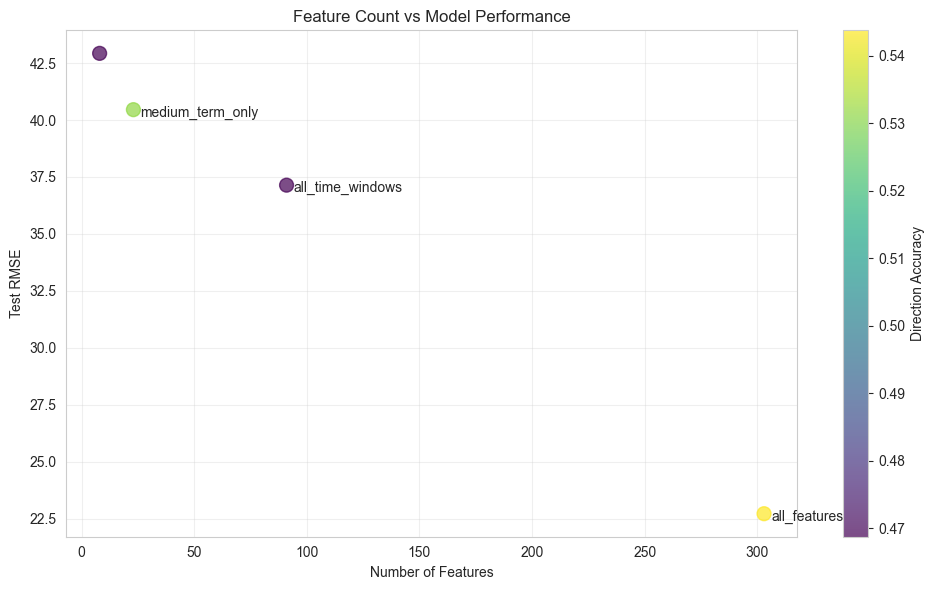

🏃 View run experiment_analysis at: http://localhost:5000/#/experiments/866255455360708975/runs/37f7a42d44444f818fec3bef42654907
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


In [15]:
# Create scatter plot: number of features vs performance
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    experiments_df['num_features'], 
    experiments_df['test_rmse'],
    c=experiments_df['test_direction_accuracy'],
    cmap='viridis',
    s=100,
    alpha=0.7
)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Direction Accuracy')

# Add labels for top performing models
for i, row in experiments_df.head(3).iterrows():
    plt.annotate(
        row['feature_set'],
        xy=(row['num_features'], row['test_rmse']),
        xytext=(5, -5),
        textcoords='offset points'
    )

plt.xlabel('Number of Features')
plt.ylabel('Test RMSE')
plt.title('Feature Count vs Model Performance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/feature_count_vs_performance.png")
plt.show()

# Log this visualization
with mlflow.start_run(run_name="experiment_analysis"):
    mlflow.log_artifact("outputs/feature_count_vs_performance.png", "analysis")
    
    # Log summary statistics
    mlflow.log_metric("num_experiments", len(experiments_df))
    mlflow.log_metric("best_rmse", experiments_df['test_rmse'].min())
    mlflow.log_metric("worst_rmse", experiments_df['test_rmse'].max())
    mlflow.log_metric("rmse_improvement_pct", 
                      (experiments_df['test_rmse'].max() - experiments_df['test_rmse'].min()) / 
                      experiments_df['test_rmse'].max() * 100)
    
    # Create and log experiment summary
    experiments_summary = experiments_df[['feature_set', 'num_features', 'test_rmse', 'test_direction_accuracy']]
    experiments_summary.to_csv("outputs/experiment_summary.csv", index=False)
    mlflow.log_artifact("outputs/experiment_summary.csv")

## 10. MLflow UI - Exploring Feature Engineering Results

After running all the experiments, we can explore them in the MLflow UI. Here's how to access and interpret the results.

### Accessing the MLflow UI

If you haven't started the MLflow tracking server, you can do so by running this command in your terminal:

```bash
mlflow server --port=5000
```

Then open your browser and navigate to: http://localhost:5000

### What to Look For in the MLflow UI

When examining your feature engineering experiments in the MLflow UI, focus on:

1. **Experiment Organization**: Navigate to the `google_stock_feature_engineering` experiment
2. **Run Comparison**: Select multiple runs and click "Compare" to see metrics side-by-side
3. **Artifacts**: Explore the logged artifacts for each run, including:
   - Feature lists
   - Feature importance plots
   - Drift analysis visualizations
4. **Sorting**: Sort runs by metrics like `test_rmse` to find the best performing feature sets
5. **Parallel Coordinates Plot**: Use this visualization to understand the relationship between parameters and metrics

### Sample Views

Here are some specific views to look for:

1. **Table View**: Sort by `test_rmse` ascending to find the best performing feature sets
2. **Scatter Plot**: Create a scatter plot with `num_features` on x-axis and `test_rmse` on y-axis to analyze how feature count affects performance
3. **Run Detail Page**: Click on the best performing run to see detailed information including model parameters, feature importance plots, and drift analysis
4. **Artifacts Tab**: Within the run detail page, check the artifacts tab to see logged visualizations and feature lists

## 11. Feature Set Versioning Strategy

Versioning feature sets is crucial for reproducibility in ML pipelines. Here's a recommended strategy for versioning feature sets with MLflow.

In [16]:
import mlflow
import os
from datetime import datetime

def create_feature_set_version(feature_set_name, features, version, description=None):
    """Create a versioned feature set and register it in MLflow"""
    with mlflow.start_run(run_name=f"feature_set_{feature_set_name}_v{version}"):
        # Log version info
        mlflow.log_param("feature_set_name", feature_set_name)
        mlflow.log_param("version", version)
        mlflow.log_param("num_features", len(features))
        
        if description:
            mlflow.log_param("description", description)
        
        # Set tags for easier querying
        mlflow.set_tag("feature_set", "true")
        mlflow.set_tag("feature_set_name", feature_set_name)
        mlflow.set_tag("version", str(version))
        mlflow.set_tag("creation_date", datetime.now().strftime("%Y-%m-%d"))
        
        # Ensure the output directory exists
        output_dir = "outputs"
        os.makedirs(output_dir, exist_ok=True)
        
        # Log feature list
        feature_list_path = os.path.join(output_dir, f"{feature_set_name}_v{version}_features.txt")
        with open(feature_list_path, "w") as f:
            f.write("\n".join(features))
        
        mlflow.log_artifact(feature_list_path)
        
        # Create and log a simple feature generation script
        feature_script = f'''# Auto-generated feature selection script for {feature_set_name} v{version}
# Created on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

def select_features(df):
    """Select features for {feature_set_name} v{version}"""
    features = [
{chr(10).join(['        "' + f + '",' for f in features])}
    ]
    
    # Return only the features that exist in the dataframe
    return [f for f in features if f in df.columns]
'''

        script_path = os.path.join(output_dir, f"{feature_set_name}_v{version}_script.py")
        with open(script_path, "w") as f:
            f.write(feature_script)
        
        mlflow.log_artifact(script_path)
        
        return mlflow.active_run().info.run_id

# Create a versioned feature set from our best performer
if best_feature_set_name in time_feature_sets:
    best_features = time_feature_sets[best_feature_set_name]
elif best_feature_set_name in statistical_feature_sets:
    best_features = statistical_feature_sets[best_feature_set_name]
else:
    best_features = [col for col in train_df.columns if col not in ['Date', 'target']]

# Version the best feature set
run_id = create_feature_set_version(
    "google_stock_best_features", 
    best_features, 
    version="1.0",
    description=f"Best performing feature set derived from {best_feature_set_name}"
)

print(f"Created feature set version 1.0 with run_id: {run_id}")


🏃 View run feature_set_google_stock_best_features_v1.0 at: http://localhost:5000/#/experiments/866255455360708975/runs/0d927d8039724b6a93d202794d1db81a
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975
Created feature set version 1.0 with run_id: 0d927d8039724b6a93d202794d1db81a


## 12. Retrieving Versioned Feature Sets

Now let's create a function to retrieve versioned feature sets from MLflow. This is essential for ensuring reproducibility in your ML pipeline.

In [17]:
def get_feature_set(feature_set_name, version="latest"):
    """Retrieve a feature set by name and version from MLflow"""
    client = MlflowClient()
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
    # Query for feature set runs
    if version == "latest":
        # Get the latest version
        runs = client.search_runs(
            experiment_ids=[experiment_id],
            filter_string=f"tags.feature_set = 'true' and tags.feature_set_name = '{feature_set_name}'",
            order_by=["attribute.start_time DESC"],
            max_results=1
        )
    else:
        # Get specific version
        runs = client.search_runs(
            experiment_ids=[experiment_id],
            filter_string=f"tags.feature_set = 'true' and tags.feature_set_name = '{feature_set_name}' and tags.version = '{version}'",
            max_results=1
        )
    
    if not runs:
        raise ValueError(f"No feature set found with name {feature_set_name} and version {version}")
    
    run = runs[0]
    
    # Download feature list artifact
    local_dir = client.download_artifacts(run.info.run_id, "")
    feature_files = [f for f in os.listdir(local_dir) if f.endswith("_features.txt")]
    
    if not feature_files:
        raise ValueError(f"No feature list found in run {run.info.run_id}")
    
    # Read feature list
    with open(os.path.join(local_dir, feature_files[0]), "r") as f:
        features = [line.strip() for line in f.readlines()]
    
    print(f"Retrieved feature set '{feature_set_name}' version {run.data.tags.get('version', 'unknown')}")
    print(f"Run ID: {run.info.run_id}")
    print(f"Created on: {datetime.fromtimestamp(run.info.start_time/1000).strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Number of features: {len(features)}")
    
    return features, run.info.run_id

# Retrieve our feature set
try:
    features, run_id = get_feature_set("google_stock_best_features", version="1.0")
    print(f"\nFirst 10 features:\n{features[:10]}")
except ValueError as e:
    print(f"Error: {e}")

Retrieved feature set 'google_stock_best_features' version 1.0
Run ID: 0d927d8039724b6a93d202794d1db81a
Created on: 2025-02-19 14:16:48
Number of features: 303

First 10 features:
['Adj Close', 'Volume', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4', 'Volume_lag_5', 'Volume_lag_6', 'Volume_lag_7', 'Volume_lag_8']


## 13. Summary and Best Practices

In this notebook, we've learned how to track, version, and evaluate different feature engineering strategies using MLflow. Here are some key takeaways and best practices:

### Key Takeaways

1. **Feature Engineering Tracking**: MLflow provides a systematic way to track different feature sets and their performance

2. **Feature Selection Approaches**:
   - Time-based window selection (short/medium/long term)
   - Statistical selection (correlation, mutual information)
   - Combined approaches often yield the best results

3. **Feature Drift Analysis**: Monitoring how feature distributions change over time is critical for time series models

4. **Feature Set Versioning**: Creating versioned feature sets ensures reproducibility across your ML pipeline

### Best Practices for Feature Engineering with MLflow

1. **Log Everything**:
   - Feature selection criteria and parameters
   - Feature lists (both selected and rejected)
   - Performance metrics for each feature set
   - Feature importance visualizations
   - Drift analysis results

2. **Consistent Naming**:
   - Use descriptive run names
   - Tag runs with feature engineering approach
   - Version feature sets systematically

3. **Experiment Organization**:
   - Create separate experiments for feature engineering
   - Use tags to categorize runs
   - Link feature engineering runs to model training runs

4. **Reproducibility**:
   - Log feature selection code as artifacts
   - Create retrievable feature set versions
   - Include metadata about how features were created

5. **Domain Knowledge**:
   - Balance statistical selection with domain understanding
   - Consider feature interpretability alongside performance
   - Document the reasoning behind feature choices

By following these practices, you can create a robust, reproducible feature engineering workflow that integrates smoothly with your MLOps pipeline.

## Next Steps

In the next lesson, we'll learn how to use the MLflow Model Registry to manage model versions and transitions through the model lifecycle stages.

Key topics will include:
1. Registering models trained with different feature sets
2. Transitioning models through staging environments
3. Model versioning and rollback strategies
4. Automating model deployment based on performance criteria